# A ton of adhoc EDA, SPLIT, and TRANSFORM
To inspect the effectiveness of the model developed, we have to hold out a part of the data, and this split machanism can only be date-oriented. Caution: preventing info leaking.
To obtain an overall view of the ratio between test and train dataset, we have to run several query like below, so that obtaining result like:

split	total	
test_set   27609
train_set  256698

In this case, when using 2018-10-7 as the split date, we have about 9.7% data for verification.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sql = """
SELECT
  a.split,
  COUNT(*) AS total
FROM (
  SELECT
    CASE
      WHEN announced_on > "2018-10-7" THEN "test_set"
    ELSE
    "train_set"
  END
    AS split
  FROM
    `proj.dataset.mbt_funding`) a
GROUP BY
  a.split
"""
split_date = "2018-10-07"

## Obtain train dataset

In [2]:
# df = pd.read_json('../data/org_snapshot.json', lines = True) # for dev only
df = pd.read_json('../data/org.json', lines = True)
# only use non-null records
df = df[df.founded_on.notnull()]
# isolate the orgs founded before split date
from trans_func import process_founded
df['weeks_founded']=df['founded_on'].apply(process_founded)
df = df[df['weeks_founded'] >= 0]
# remove the columns that needs to be reconstructed from funding table
df["company_uuid"] = df['uuid']
df = df.drop(columns=['funding_rounds', 'funding_total_usd', 'last_funding_on', 'founded_on', 'uuid'])
df.head()

,company_name,homepage_url,country_code,city,short_description,description,employee_count,weeks_founded,company_uuid
0,BN Media,http://bnmediallc.com,,,BN Media is an entity that features three cros...,The mission of BN Media is to serve the vast o...,11-50,457.285714,51d72ce7-3075-b4d9-941f-8a90b23c9c14
1,BSN Glasspack,http://www.bsnglasspack.com/,,,The second-largest glass container maker in Eu...,NaN,unknown,979.142857,62a90659-df0d-0ff8-c30e-b393bdbbb490
5,FastGrowth Company,http://fastgrowthco.com/,,,On Demand Sales Consulting and Services Company,NaN,1-10,131.285714,fd8e506a-5190-df18-1e56-fd7ca05af161
10,MenFashion.pk,http://menfashion.pk,,,MenFashion.pk is Pakistan largest men fashion ...,Visit MenFashion.pk to check out trendy and fa...,1-10,135.714286,bfc7b9b4-9016-d808-7224-46f541a4fb64
11,NameEngine,http://www.thenameengine.com,,,NameEngine is a website providing correct name...,NaN,1-10,613.857143,672d87af-4eeb-ddc9-778e-97b0750538ae


### homepage_url

In [3]:
import re
def process_homepage_url(x):
    return re.sub('[^a-zA-Z]+', '', x.split('.')[-1].strip())
df['homepage_url'] = df['homepage_url'].apply(process_homepage_url)
df.head()

,company_name,homepage_url,country_code,city,short_description,description,employee_count,weeks_founded,company_uuid
0,BN Media,com,,,BN Media is an entity that features three cros...,The mission of BN Media is to serve the vast o...,11-50,457.285714,51d72ce7-3075-b4d9-941f-8a90b23c9c14
1,BSN Glasspack,com,,,The second-largest glass container maker in Eu...,NaN,unknown,979.142857,62a90659-df0d-0ff8-c30e-b393bdbbb490
5,FastGrowth Company,com,,,On Demand Sales Consulting and Services Company,NaN,1-10,131.285714,fd8e506a-5190-df18-1e56-fd7ca05af161
10,MenFashion.pk,pk,,,MenFashion.pk is Pakistan largest men fashion ...,Visit MenFashion.pk to check out trendy and fa...,1-10,135.714286,bfc7b9b4-9016-d808-7224-46f541a4fb64
11,NameEngine,com,,,NameEngine is a website providing correct name...,NaN,1-10,613.857143,672d87af-4eeb-ddc9-778e-97b0750538ae


### Process announced_on

In [4]:
# filter funding table
dff = pd.read_json('../data/funding.json', lines = True)
dff['weeks_announced']=dff['announced_on'].apply(process_founded)
dff = dff[dff['weeks_announced'] >= 0]
dff = dff.drop(columns=['announced_on', 'company_name'])
# dff['raised_amount_usd'] = dff['raised_amount_usd'].astype(int)
dff = dff.sort_values(by ='weeks_announced' )
dff.head()

,funding_round_uuid,company_uuid,investment_type,raised_amount_usd,investor_names,investor_count,weeks_announced
117894,a589f441-4853-4abf-b1aa-47fc8172971e,c8902f02-bb9b-4d3b-b94a-33bced7204de,pre_seed,NaN,{},NaN,0.0
121280,04e01228-a9a3-4780-9d2b-a5433fe14fda,471d3c29-ad2d-9a3c-f9f0-8b539c810cbf,pre_seed,NaN,{},1.0,0.0
49373,e1d126e5-52ba-45bf-9e6b-8357a0a6cb21,cfadcd1d-36e5-43cf-90d1-e7a258f947e3,seed,2249000.0,{},1.0,0.0
53272,087d4061-3b5c-4f0a-a920-08ad013d5223,6608f85a-2407-4ad7-aea8-d424dd7a5e34,seed,1000000.0,"{""Newtown Partners""}",1.0,0.0
274955,359c533e-e38b-468e-8818-fa787ef24560,928fe6d8-65ea-4b48-8521-d2265ea5fccc,equity_crowdfunding,172867.0,{},NaN,0.0


(0, 1500)

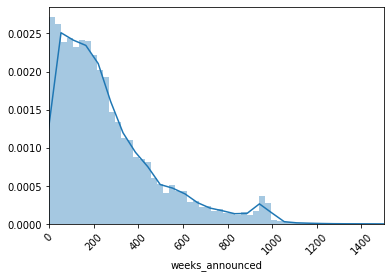

In [5]:
# weeks_announced distribution
ax = sns.distplot(dff['weeks_announced'], bins=200)
plt.xticks(rotation=45)
ax.set_xlim(0, 1500)

In [6]:
# Bucketing weeks_announced
# buckets: 2 weeks, 4 weeks, 8 weeks, 12 weeks (approx. 3 months), 
#          24 weeks (6 months), 48 weeks (1 year), 96 weeks (2 years), 
#          144 weeks (3 years), 192 weeks (4 years), 240 weeks (5 years), 480 weeks (10 years), over 10 years
segs_weeks_announced = [2, 4, 8, 12, 24, 48, 96, 144, 192, 240, 480]
n_segs_weeks_announced = len(segs_weeks_announced)
def get_seg_weeks_announced(x):
    for i in range(n_segs_weeks_announced):
        if x > segs_weeks_announced[i]:
            continue
        else:
            return i
    return n_segs_weeks_announced
    
def process_weeks_announced(x):
    result = [0 for i in range(n_segs_weeks_announced + 1)]
    if x == np.nan:
        return result
    result[get_seg_weeks_announced(x)] = 1
    return result
    
dff['weeks_announced_quant']=dff['weeks_announced'].apply(process_weeks_announced)
dff.head()

,funding_round_uuid,company_uuid,investment_type,raised_amount_usd,investor_names,investor_count,weeks_announced,weeks_announced_quant
117894,a589f441-4853-4abf-b1aa-47fc8172971e,c8902f02-bb9b-4d3b-b94a-33bced7204de,pre_seed,NaN,{},NaN,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
121280,04e01228-a9a3-4780-9d2b-a5433fe14fda,471d3c29-ad2d-9a3c-f9f0-8b539c810cbf,pre_seed,NaN,{},1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
49373,e1d126e5-52ba-45bf-9e6b-8357a0a6cb21,cfadcd1d-36e5-43cf-90d1-e7a258f947e3,seed,2249000.0,{},1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
53272,087d4061-3b5c-4f0a-a920-08ad013d5223,6608f85a-2407-4ad7-aea8-d424dd7a5e34,seed,1000000.0,"{""Newtown Partners""}",1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
274955,359c533e-e38b-468e-8818-fa787ef24560,928fe6d8-65ea-4b48-8521-d2265ea5fccc,equity_crowdfunding,172867.0,{},NaN,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [7]:
df['weeks_founded_quant'] = df['weeks_founded'].apply(process_weeks_announced)
df.head()

,company_name,homepage_url,country_code,city,short_description,description,employee_count,weeks_founded,company_uuid,weeks_founded_quant
0,BN Media,com,,,BN Media is an entity that features three cros...,The mission of BN Media is to serve the vast o...,11-50,457.285714,51d72ce7-3075-b4d9-941f-8a90b23c9c14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,BSN Glasspack,com,,,The second-largest glass container maker in Eu...,NaN,unknown,979.142857,62a90659-df0d-0ff8-c30e-b393bdbbb490,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
5,FastGrowth Company,com,,,On Demand Sales Consulting and Services Company,NaN,1-10,131.285714,fd8e506a-5190-df18-1e56-fd7ca05af161,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
10,MenFashion.pk,pk,,,MenFashion.pk is Pakistan largest men fashion ...,Visit MenFashion.pk to check out trendy and fa...,1-10,135.714286,bfc7b9b4-9016-d808-7224-46f541a4fb64,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
11,NameEngine,com,,,NameEngine is a website providing correct name...,NaN,1-10,613.857143,672d87af-4eeb-ddc9-778e-97b0750538ae,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


### investment_type

In [8]:
# preprocess investment_type into simpler case-specific feature to the following
# PreAB (1 0 0): investment before A/B series
# PostAB (0 1 0): investment after A/B series
# AB (0 0 1): A/B series investment
# non-specific (1 1 1): can happen at any stage
# series_unknown (0 1 1)
# undisclosed (0 0 0)
from trans_func import process_investment_type  
dff['invest_phase']=dff['investment_type'].apply(process_investment_type)
dff = dff.drop(columns=['investment_type'])
dff.head()

,funding_round_uuid,company_uuid,raised_amount_usd,investor_names,investor_count,weeks_announced,weeks_announced_quant,invest_phase
117894,a589f441-4853-4abf-b1aa-47fc8172971e,c8902f02-bb9b-4d3b-b94a-33bced7204de,NaN,{},NaN,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]"
121280,04e01228-a9a3-4780-9d2b-a5433fe14fda,471d3c29-ad2d-9a3c-f9f0-8b539c810cbf,NaN,{},1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]"
49373,e1d126e5-52ba-45bf-9e6b-8357a0a6cb21,cfadcd1d-36e5-43cf-90d1-e7a258f947e3,2249000.0,{},1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]"
53272,087d4061-3b5c-4f0a-a920-08ad013d5223,6608f85a-2407-4ad7-aea8-d424dd7a5e34,1000000.0,"{""Newtown Partners""}",1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]"
274955,359c533e-e38b-468e-8818-fa787ef24560,928fe6d8-65ea-4b48-8521-d2265ea5fccc,172867.0,{},NaN,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]"


### Preprocess investor_names

In [9]:
# investor_names might be useful to identify company business semantics
import re
def process_investor_names(x):
    return  re.sub("\{|\}|\"", "", x.lower()).split(',')

def concat_investor_names(x):
    result = ""
    for entry in x:
        if len(entry) < 1:
            continue
        result += (" " + entry)
    return result
    
dff['investor_names'] = dff['investor_names'].apply(process_investor_names)
dff['investor_names_concat'] = dff['investor_names'].apply(concat_investor_names)
dff.head()

,funding_round_uuid,company_uuid,raised_amount_usd,investor_names,investor_count,weeks_announced,weeks_announced_quant,invest_phase,investor_names_concat
117894,a589f441-4853-4abf-b1aa-47fc8172971e,c8902f02-bb9b-4d3b-b94a-33bced7204de,NaN,[],NaN,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]",
121280,04e01228-a9a3-4780-9d2b-a5433fe14fda,471d3c29-ad2d-9a3c-f9f0-8b539c810cbf,NaN,[],1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]",
49373,e1d126e5-52ba-45bf-9e6b-8357a0a6cb21,cfadcd1d-36e5-43cf-90d1-e7a258f947e3,2249000.0,[],1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]",
53272,087d4061-3b5c-4f0a-a920-08ad013d5223,6608f85a-2407-4ad7-aea8-d424dd7a5e34,1000000.0,[newtown partners],1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]",newtown partners
274955,359c533e-e38b-468e-8818-fa787ef24560,928fe6d8-65ea-4b48-8521-d2265ea5fccc,172867.0,[],NaN,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]",


### bucketizing raised_amount_usd

In [10]:
# bucketizing raised_amount_usd
dff['raised_amount_usd'].describe()

count    1.873530e+05
mean     1.343819e+07
std      1.354589e+08
min      0.000000e+00
25%      3.000000e+05
50%      1.539988e+06
75%      7.000000e+06
max      2.180169e+10
Name: raised_amount_usd, dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

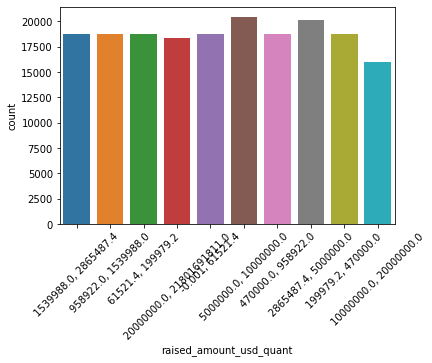

In [11]:
dff['raised_amount_usd_quant'] = pd.qcut(dff['raised_amount_usd'], q=10)
dff['raised_amount_usd_quant'] = dff['raised_amount_usd_quant'].astype(str).str.strip('()[]')
ax = sns.countplot(x="raised_amount_usd_quant", data=dff[dff['raised_amount_usd_quant'] != 'nan'])
plt.xticks(rotation=45)

In [12]:
bucket_names = list(dff.raised_amount_usd_quant.unique()) # [str(x) for x in list(dff.raised_amount_usd_quant.unique())]
bucket_names.remove('nan')
def process_raised_amount_usd_quant(x):
    x = str(x)
    result = [0 for i in range(10)]
    if x == 'nan':
        return result
    else:
        result[bucket_names.index(x)] = 1
        return result
    
dff['raised_amount_usd_quant'] = dff['raised_amount_usd_quant'].apply(process_raised_amount_usd_quant)
dff.head()

,funding_round_uuid,company_uuid,raised_amount_usd,investor_names,investor_count,weeks_announced,weeks_announced_quant,invest_phase,investor_names_concat,raised_amount_usd_quant
117894,a589f441-4853-4abf-b1aa-47fc8172971e,c8902f02-bb9b-4d3b-b94a-33bced7204de,NaN,[],NaN,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]",,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
121280,04e01228-a9a3-4780-9d2b-a5433fe14fda,471d3c29-ad2d-9a3c-f9f0-8b539c810cbf,NaN,[],1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]",,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
49373,e1d126e5-52ba-45bf-9e6b-8357a0a6cb21,cfadcd1d-36e5-43cf-90d1-e7a258f947e3,2249000.0,[],1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]",,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
53272,087d4061-3b5c-4f0a-a920-08ad013d5223,6608f85a-2407-4ad7-aea8-d424dd7a5e34,1000000.0,[newtown partners],1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]",newtown partners,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
274955,359c533e-e38b-468e-8818-fa787ef24560,928fe6d8-65ea-4b48-8521-d2265ea5fccc,172867.0,[],NaN,0.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0]",,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [13]:
employee_bucket_names = list(df.employee_count.unique())
def process_employee_count(x):
    x = str(x)
    result = [0 for i in range(10)]
    if x == 'nan':
        return result
    else:
        result[employee_bucket_names.index(x)] = 1
        return result
    
df['employee_count_quant'] = df['employee_count'].apply(process_employee_count)
df.head(n=2)

,company_name,homepage_url,country_code,city,short_description,description,employee_count,weeks_founded,company_uuid,weeks_founded_quant,employee_count_quant
0,BN Media,com,,,BN Media is an entity that features three cros...,The mission of BN Media is to serve the vast o...,11-50,457.285714,51d72ce7-3075-b4d9-941f-8a90b23c9c14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,BSN Glasspack,com,,,The second-largest glass container maker in Eu...,NaN,unknown,979.142857,62a90659-df0d-0ff8-c30e-b393bdbbb490,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


### Process and impute investor_count

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

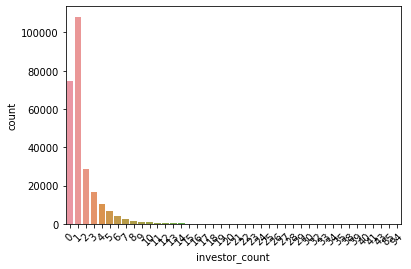

In [14]:
dff['investor_count'] = dff['investor_count'].fillna(0).astype(int)
dff['investor_count_imp'] = (dff['investor_count'] == 0).astype(int)
ax = sns.countplot(x="investor_count", data=dff)
plt.xticks(rotation=45)

In [15]:
# log transform for investor_count since the numerical difference is more sensitive when the number is smaller
dff['investor_count_log'] = np.log(dff['investor_count'] + 1.0)
dff.tail()

,funding_round_uuid,company_uuid,raised_amount_usd,investor_names,investor_count,weeks_announced,weeks_announced_quant,invest_phase,investor_names_concat,raised_amount_usd_quant,investor_count_imp,investor_count_log
188212,518b5cd3-17f2-bc76-8560-d1a7bee2282c,6681b1b0-0cea-6a4a-820d-60b15793fa66,549000.0,[],0,2492.428571,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0]",,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1,0.000000
75175,24093d19-1f1d-ae85-64fe-557d2d08b368,1e4f199c-363b-451b-a164-f94571075ee5,2510000.0,[],2,2618.571429,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0, 0]",,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,1.098612
10103,a8f6664d-22d2-4c4e-9c7a-84817938cc24,c339b2e4-9a26-4f0f-bbdc-66bcfa7e02b7,NaN,[],0,5166.571429,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0, 0]",,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,0.000000
85373,4ba3c5da-3351-4454-bdef-b2b6d6759fca,9b4b6f42-65c4-4712-ab2f-4da94a2e3e6f,819408.0,[],6,5201.142857,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0, 0]",,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",0,1.945910
65593,ab9e1228-04cd-4d23-8fee-87f97f45e282,ed283b50-2c65-4855-9129-0d4bbc5f8368,3255157.0,[],1,5386.428571,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0, 0]",,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",0,0.693147


### Correlation between investor_names and invest_phase

In [16]:
investor_dict = {}
for index, row in dff.iterrows():
    investor_names = row['investor_names']
    invest_phase = row['invest_phase']
    for investor in investor_names:
        if len(investor) < 1:
            continue
        if investor in investor_dict:
            investor_dict[investor][0] += 1
            investor_dict[investor][1] = [sum(x) for x in zip(investor_dict[investor][1], invest_phase)]
        else:
            investor_dict[investor] = [0, [0, 0, 0]]
            
print('Averaging investor profile vector ...')
investor_vec = {}
for key,val in investor_dict.items(): 
    if val[0] < 1:
        investor_vec[key] = val[1]
    else:
        investor_vec[key] = [x/val[0] for x in val[1]]

Averaging investor profile vector ...


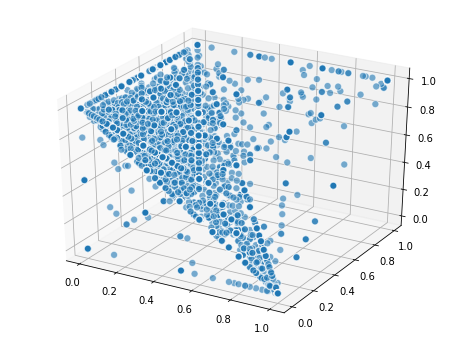

In [17]:
# Visualizing investor vector concerning investment phase
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
investor_vec_var = np.asarray(list(investor_vec.values()))
np.savetxt("./investor_vec_var.csv", investor_vec_var, delimiter=",")
xs = investor_vec_var[:, 0]
ys = investor_vec_var[:, 1]
zs = investor_vec_var[:, 2]
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

plt.show()

In [18]:
# Use mean vector to replace investor_names
def process_investor_vector(x):
    n = len(x)
    result = [0, 0, 0]
    for key in x:
        if len(key) < 1:
            n -= 1
        else:
            result = [sum(x) for x in zip(result, investor_vec[key])]
    if n < 1:
        return result
    else:
        return [x/n for x in result]
    
dff['investor_names'] = dff['investor_names'].apply(process_investor_vector)
dff.tail()

,funding_round_uuid,company_uuid,raised_amount_usd,investor_names,investor_count,weeks_announced,weeks_announced_quant,invest_phase,investor_names_concat,raised_amount_usd_quant,investor_count_imp,investor_count_log
188212,518b5cd3-17f2-bc76-8560-d1a7bee2282c,6681b1b0-0cea-6a4a-820d-60b15793fa66,549000.0,"[0, 0, 0]",0,2492.428571,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0]",,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1,0.000000
75175,24093d19-1f1d-ae85-64fe-557d2d08b368,1e4f199c-363b-451b-a164-f94571075ee5,2510000.0,"[0, 0, 0]",2,2618.571429,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0, 0]",,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,1.098612
10103,a8f6664d-22d2-4c4e-9c7a-84817938cc24,c339b2e4-9a26-4f0f-bbdc-66bcfa7e02b7,NaN,"[0, 0, 0]",0,5166.571429,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0, 0]",,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,0.000000
85373,4ba3c5da-3351-4454-bdef-b2b6d6759fca,9b4b6f42-65c4-4712-ab2f-4da94a2e3e6f,819408.0,"[0, 0, 0]",6,5201.142857,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0, 0]",,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",0,1.945910
65593,ab9e1228-04cd-4d23-8fee-87f97f45e282,ed283b50-2c65-4855-9129-0d4bbc5f8368,3255157.0,"[0, 0, 0]",1,5386.428571,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0, 0]",,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",0,0.693147


### finalizing funding training data table

In [19]:
dff = dff.drop(columns=['funding_round_uuid'])

In [20]:
# This might take long
dff = dff.groupby('company_uuid').agg(lambda x: x.tolist())

In [21]:
dff.head()

,raised_amount_usd,investor_names,investor_count,weeks_announced,weeks_announced_quant,invest_phase,investor_names_concat,raised_amount_usd_quant,investor_count_imp,investor_count_log
company_uuid,,,,,,,,,,
00000aa4-ba42-9b68-a9c3-040c9f3bf9b9,[82607363.0],"[[0.0, 0.5294117647058824, 0.7058823529411765]]",[1],[63.857142857142854],"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 1]]",[ citic capital holdings],"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]",[0],[0.6931471805599453]
000014da-0c46-b9cb-0941-3a93c027b119,"[nan, nan, nan, nan, nan]","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[3, 1, 1, 1, 2]","[32.285714285714285, 56.42857142857143, 68.428...","[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, ...","[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [...","[, , , , ]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[0, 0, 0, 0, 0]","[1.3862943611198906, 0.6931471805599453, 0.693..."
00002470-bff7-6226-5800-0ca1b3787b6f,"[1600000.0, 1200000.0, nan, 600000.0, nan]","[[0.11538461538461539, 0.11538461538461539, 0....","[1, 4, 2, 5, 3]","[94.57142857142857, 162.57142857142858, 204.42...","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, ...","[[1, 0, 0], [1, 0, 0], [0, 1, 1], [1, 0, 0], [...","[ wi harper group, , fg angels, , ]","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, ...","[0, 0, 0, 0, 0]","[0.6931471805599453, 1.6094379124341003, 1.098..."
000095de-8e2b-82f1-32a7-c222ba3d5682,[9500000.0],"[[0.0, 0.4444444444444444, 0.7777777777777778]]",[1],[903.8571428571429],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]","[[0, 1, 1]]",[ capital z partners],"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]",[0],[0.6931471805599453]
0000d497-c93a-eea3-eeb0-a943dfb4f71e,"[431575.0, nan]","[[0, 0, 0], [0.975, 0.025, 0.025]]","[0, 1]","[89.71428571428571, 150.71428571428572]","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, ...","[[0, 1, 1], [1, 0, 0]]","[, borean innovation]","[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, ...","[1, 0]","[0.0, 0.6931471805599453]"


### Left Join two tables

In [22]:
zf = pd.merge(df, dff, on='company_uuid', how='left')
print(zf.shape)
zf[zf.raised_amount_usd.notnull()].head()

(563747, 21)


,company_name,homepage_url,country_code,city,short_description,description,employee_count,weeks_founded,company_uuid,weeks_founded_quant,...,raised_amount_usd,investor_names,investor_count,weeks_announced,weeks_announced_quant,invest_phase,investor_names_concat,raised_amount_usd_quant,investor_count_imp,investor_count_log
145,Beeologics,com,,,Beeologics is an international firm dedicated ...,Beeologics is an international firm dedicated ...,10000+,613.857143,53ffedec-60c4-d3f4-9896-e0a4da5fe4c4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,[nan],"[[0, 0, 0]]",[1],[540.1428571428571],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]","[[1, 0, 0]]",[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",[0],[0.6931471805599453]
179,ICT Biometrics/Cybertouch,,,,Cybersecurity biometrics,Biometric technology for global enterprises,11-50,1240.000000,9ad77abe-6b48-4fff-b425-9388185426ea,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,[nan],"[[0, 0, 0]]",[0],[1079.0],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]","[[0, 1, 0]]",[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",[1],[0.0]
209,LivingSwag,com,,,"Find out daily living swag and tips, discounts...","Find out daily living swag and tips, discounts...",1-10,22.714286,afaacad9-f3b7-4730-b779-745023acc743,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",...,[1000.0],"[[0, 0, 0]]",[0],[22.285714285714285],"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]","[[0, 1, 0]]",[],"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]",[1],[0.0]
297,"Xchange, Inc.",,,,Xchange is a location-based AI-driven business...,Xchange is a location-based AI-driven business...,unknown,78.714286,3b6cca2e-1afe-8928-896c-28ae0fe1fed6,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",...,[12000.0],"[[0, 0, 0]]",[0],[77.85714285714286],"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]","[[1, 0, 0]]",[],"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]",[1],[0.0]
309,Expirenza,com,,,Expirenza is an online SaaS CEM platform whic...,Expirenza - customer experience (CX) intellige...,11-50,91.428571,9579073d-dc5a-4962-90a7-546beabab14b,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",...,[100000.0],"[[0, 0, 0]]",[0],[39.714285714285715],"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0]]",[],"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]",[1],[0.0]


### Add funding_total_usd aggregated feature

In [23]:
def get_funding_total_usd(x):
    if x == np.nan:
        return 0
    return np.nansum(x)
    
zf['funding_total_usd'] = zf['raised_amount_usd'].apply(get_funding_total_usd)


In [24]:
import numbers
def process_general_usd(x):
    if x < 1 or (not isinstance(x, numbers.Number)):
        return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    elif x < 5000:
        return [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    elif x < 50000:
        return [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    elif x < 500000:
        return [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    elif x < 2000000:
        return [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    elif x < 5000000:
        return [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    elif x < 10000000:
        return [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    elif x < 50000000:
        return [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
    elif x < 200000000:
        return [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
    elif x < 1000000000:
        return [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
    else:
        return [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    
zf['funding_total_usd_quant'] = zf['funding_total_usd'].apply(process_general_usd)
zf[zf['funding_total_usd']>0]

,company_name,homepage_url,country_code,city,short_description,description,employee_count,weeks_founded,company_uuid,weeks_founded_quant,...,investor_count,weeks_announced,weeks_announced_quant,invest_phase,investor_names_concat,raised_amount_usd_quant,investor_count_imp,investor_count_log,funding_total_usd,funding_total_usd_quant
209,LivingSwag,com,,,"Find out daily living swag and tips, discounts...","Find out daily living swag and tips, discounts...",1-10,22.714286,afaacad9-f3b7-4730-b779-745023acc743,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",...,[0],[22.285714285714285],"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]","[[0, 1, 0]]",[],"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]",[1],[0.0],1000.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
297,"Xchange, Inc.",,,,Xchange is a location-based AI-driven business...,Xchange is a location-based AI-driven business...,unknown,78.714286,3b6cca2e-1afe-8928-896c-28ae0fe1fed6,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",...,[0],[77.85714285714286],"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]","[[1, 0, 0]]",[],"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]",[1],[0.0],12000.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
309,Expirenza,com,,,Expirenza is an online SaaS CEM platform whic...,Expirenza - customer experience (CX) intellige...,11-50,91.428571,9579073d-dc5a-4962-90a7-546beabab14b,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",...,[0],[39.714285714285715],"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0]]",[],"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]",[1],[0.0],100000.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
467,PreCious Watches Oy,net,FIN,Espoo,"PreCious Watches develops, manufactures, and m...",PreCious Watches is a Finnish company that dev...,1-10,155.571429,407e86c9-e3cd-d5ea-0dcd-cb6adfef2c91,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",...,[0],[135.42857142857142],"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]","[[1, 0, 0]]",[],"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]",[1],[0.0],76000.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
473,Viatori App,tr,TUR,Izmir,Viatori is a free photo and video sharing appl...,Viatori is a free photo and video sharing appl...,1-10,139.714286,b2799ac9-9718-4416-b19d-12b829ba8015,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",...,"[0, 0]","[87.57142857142857, 139.71428571428572]","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, ...","[[1, 0, 0], [1, 0, 0]]","[, ]","[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, ...","[1, 1]","[0.0, 0.0]",500000.0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563723,mmCHANNEL,com,ESP,Pozuelo De Alarcón,MmCHANNEL is a multimedia company that provide...,mmCHANNEL is a global leader in multimedia ena...,11-50,805.428571,3af95038-0b50-c287-9dd7-2ccc111d7792,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,"[0, 1]","[553.1428571428571, 557.2857142857143]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, ...","[[0, 1, 1], [0, 0, 1]]","[, ]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[1, 0]","[0.0, 0.6931471805599453]",2966412.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
563732,Oncobox,com,USA,Walnut,Oncobox is low-cost personalized genetic profi...,OncoBox is cost-effective personalized genetic...,11-50,196.428571,12d3a34a-8a1f-f9a0-5707-a49e6a25e529,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",...,[1],[58.857142857142854],"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]","[[1, 0, 0]]",[],"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]",[0],[0.6931471805599453],120000.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
563736,RCBI,org,USA,Huntington,RCBI involves a network of advanced manufactur...,RCBI involves a network of advanced manufactur...,unknown,1500.857143,5a9aeff7-00ff-6759-26d2-060818b00b6a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,[1],[76.42857142857143],"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]","[[1, 0, 0]]",[ us department of commerce economic developm...,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]",[0],[0.6931471805599453],1300000.0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
563738,Akumina,com,USA,Nashua,The employee experience platform that empowers...,Akumina is the Employee Experience Platform th...,11-50,196.428571,6a233df2

### Add funding_rounds

In [25]:
def get_funding_rounds(x):
    if type(x) is not list:
        return 0
    return len(x)
    
zf['funding_rounds'] = np.log(zf['raised_amount_usd'].apply(get_funding_rounds) + 1.0)
zf[zf['funding_rounds']>0]

,company_name,homepage_url,country_code,city,short_description,description,employee_count,weeks_founded,company_uuid,weeks_founded_quant,...,weeks_announced,weeks_announced_quant,invest_phase,investor_names_concat,raised_amount_usd_quant,investor_count_imp,investor_count_log,funding_total_usd,funding_total_usd_quant,funding_rounds
145,Beeologics,com,,,Beeologics is an international firm dedicated ...,Beeologics is an international firm dedicated ...,10000+,613.857143,53ffedec-60c4-d3f4-9896-e0a4da5fe4c4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,[540.1428571428571],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]","[[1, 0, 0]]",[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",[0],[0.6931471805599453],0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.693147
179,ICT Biometrics/Cybertouch,,,,Cybersecurity biometrics,Biometric technology for global enterprises,11-50,1240.000000,9ad77abe-6b48-4fff-b425-9388185426ea,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,[1079.0],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]","[[0, 1, 0]]",[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",[1],[0.0],0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.693147
209,LivingSwag,com,,,"Find out daily living swag and tips, discounts...","Find out daily living swag and tips, discounts...",1-10,22.714286,afaacad9-f3b7-4730-b779-745023acc743,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",...,[22.285714285714285],"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]","[[0, 1, 0]]",[],"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]",[1],[0.0],1000.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.693147
297,"Xchange, Inc.",,,,Xchange is a location-based AI-driven business...,Xchange is a location-based AI-driven business...,unknown,78.714286,3b6cca2e-1afe-8928-896c-28ae0fe1fed6,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",...,[77.85714285714286],"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]","[[1, 0, 0]]",[],"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]",[1],[0.0],12000.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",0.693147
309,Expirenza,com,,,Expirenza is an online SaaS CEM platform whic...,Expirenza - customer experience (CX) intellige...,11-50,91.428571,9579073d-dc5a-4962-90a7-546beabab14b,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",...,[39.714285714285715],"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0]]",[],"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]",[1],[0.0],100000.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563733,CHARMS PPEC,com,USA,Port St. Lucie,We are wanting to open a prescribed pediatric ...,We are wanting to open a prescribed pediatric...,1-10,283.428571,c92610f1-89f9-5f1b-4f8b-7a6d505f8f4c,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",...,[262.14285714285717],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]","[[1, 0, 0]]",[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",[1],[0.0],0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.693147
563736,RCBI,org,USA,Huntington,RCBI involves a network of advanced manufactur...,RCBI involves a network of advanced manufactur...,unknown,1500.857143,5a9aeff7-00ff-6759-26d2-060818b00b6a,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,[76.42857142857143],"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]","[[1, 0, 0]]",[ us department of commerce economic developm...,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]",[0],[0.6931471805599453],1300000.0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",0.693147
563738,Akumina,com,USA,Nashua,The employee experience platform that empowers...,Akumina is the Employee Experience Platform th...,11-50,196.428571,6a233df2-cf8c-82f4-3aca-3988fbf4f97e,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",...,"[170.71428571428572, 224.28571428571428]","[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, ...","[[1, 1, 1], [0, 1, 1]]","[, ]","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, ...","[1, 1]","[0.0, 0.0]",1289975.0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1.098612
563739,VGo Communications,com,USA,Nashua,VGo Communications develops and markets visual...,"Vgo Communications, Inc. develops and markets ...",11-50,613.857143,2275cc7f-d8c2-c69a-dc60-ee4637408367,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,"[268.57142857142856, 308.42857142857144, 385.7

### Add last_funding_week

In [26]:
def get_last_funding_week(x):
    if type(x) is not list:
        return np.nan
    return x[0]
    
zf['last_funding_week'] = zf['weeks_announced'].apply(get_last_funding_week)
zf[zf['last_funding_week']>0].head(n=2)

,company_name,homepage_url,country_code,city,short_description,description,employee_count,weeks_founded,company_uuid,weeks_founded_quant,...,weeks_announced_quant,invest_phase,investor_names_concat,raised_amount_usd_quant,investor_count_imp,investor_count_log,funding_total_usd,funding_total_usd_quant,funding_rounds,last_funding_week
145,Beeologics,com,,,Beeologics is an international firm dedicated ...,Beeologics is an international firm dedicated ...,10000+,613.857143,53ffedec-60c4-d3f4-9896-e0a4da5fe4c4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]","[[1, 0, 0]]",[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",[0],[0.6931471805599453],0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.693147,540.142857
179,ICT Biometrics/Cybertouch,,,,Cybersecurity biometrics,Biometric technology for global enterprises,11-50,1240.000000,9ad77abe-6b48-4fff-b425-9388185426ea,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]","[[0, 1, 0]]",[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",[1],[0.0],0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.693147,1079.000000


In [27]:
zf['last_funding_week_quant'] = zf['last_funding_week'].apply(process_weeks_announced)
zf[zf['last_funding_week']>0].head(n=2)

,company_name,homepage_url,country_code,city,short_description,description,employee_count,weeks_founded,company_uuid,weeks_founded_quant,...,invest_phase,investor_names_concat,raised_amount_usd_quant,investor_count_imp,investor_count_log,funding_total_usd,funding_total_usd_quant,funding_rounds,last_funding_week,last_funding_week_quant
145,Beeologics,com,,,Beeologics is an international firm dedicated ...,Beeologics is an international firm dedicated ...,10000+,613.857143,53ffedec-60c4-d3f4-9896-e0a4da5fe4c4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,"[[1, 0, 0]]",[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",[0],[0.6931471805599453],0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.693147,540.142857,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
179,ICT Biometrics/Cybertouch,,,,Cybersecurity biometrics,Biometric technology for global enterprises,11-50,1240.000000,9ad77abe-6b48-4fff-b425-9388185426ea,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,"[[0, 1, 0]]",[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",[1],[0.0],0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.693147,1079.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


### Add last_funding_usd

In [28]:
def get_last_funding_usd(x):
    if type(x) is not list:
        return 0
    if not isinstance(x[0], numbers.Number):
        return 0
    return x[0]
    
zf['last_funding_usd'] = zf['raised_amount_usd'].apply(get_last_funding_usd)
zf['last_funding_usd_quant'] = zf['last_funding_usd'].apply(process_general_usd)
zf[zf['last_funding_usd']>0].head(n=2)

,company_name,homepage_url,country_code,city,short_description,description,employee_count,weeks_founded,company_uuid,weeks_founded_quant,...,raised_amount_usd_quant,investor_count_imp,investor_count_log,funding_total_usd,funding_total_usd_quant,funding_rounds,last_funding_week,last_funding_week_quant,last_funding_usd,last_funding_usd_quant
209,LivingSwag,com,,,"Find out daily living swag and tips, discounts...","Find out daily living swag and tips, discounts...",1-10,22.714286,afaacad9-f3b7-4730-b779-745023acc743,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",...,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]",[1],[0.0],1000.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.693147,22.285714,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1000.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
297,"Xchange, Inc.",,,,Xchange is a location-based AI-driven business...,Xchange is a location-based AI-driven business...,unknown,78.714286,3b6cca2e-1afe-8928-896c-28ae0fe1fed6,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",...,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]",[1],[0.0],12000.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",0.693147,77.857143,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",12000.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


### Add has_series_ab

In [29]:
from trans_func import get_has_series_ab
zf['invest_phase_overall'] = zf['invest_phase'].apply(get_has_series_ab)
zf[zf['invest_phase_overall'].apply(lambda x: x == [1, 0])].head(n=2)

,company_name,homepage_url,country_code,city,short_description,description,employee_count,weeks_founded,company_uuid,weeks_founded_quant,...,investor_count_imp,investor_count_log,funding_total_usd,funding_total_usd_quant,funding_rounds,last_funding_week,last_funding_week_quant,last_funding_usd,last_funding_usd_quant,invest_phase_overall
179,ICT Biometrics/Cybertouch,,,,Cybersecurity biometrics,Biometric technology for global enterprises,11-50,1240.000000,9ad77abe-6b48-4fff-b425-9388185426ea,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,[1],[0.0],0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.693147,1079.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0]"
209,LivingSwag,com,,,"Find out daily living swag and tips, discounts...","Find out daily living swag and tips, discounts...",1-10,22.714286,afaacad9-f3b7-4730-b779-745023acc743,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",...,[1],[0.0],1000.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.693147,22.285714,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1000.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0]"


## Dump the processed training data

In [30]:
# add a feature last_funding_ratio before saving
zf['last_funding_ratio'] = zf['last_funding_usd'] / zf['funding_total_usd']
zf['last_funding_ratio'] = zf['last_funding_ratio'].fillna(-1).astype(float)
zf['last_funding_ratio_imp'] = (zf['last_funding_ratio'] == -1).astype(int)

zf.to_pickle("../data/train.pkl")